In [1]:
import random
import time
import os.path as osp
from pathlib import Path
from typing import Tuple
from glob import glob
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import keras_tuner as kt

2023-02-01 03:53:39.532462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 03:53:40.103808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 03:53:40.103880: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-01 03:53:40.103886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import albumentations as A
from fl_tissue_model_tools.transforms import get_elastic_dual_transform
from fl_tissue_model_tools.preprocessing import get_augmentor, get_batch_augmentor

In [3]:
from tensorflow import test, device
# from tensorflow import keras 
from tensorflow.keras import backend, Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU
from tensorflow.keras.optimizers import RMSprop

In [4]:
from fl_tissue_model_tools import defs, models
import fl_tissue_model_tools.preprocessing as prep
from fl_tissue_model_tools.helper import get_img_mask_paths

# Validate data paths

In [5]:
images_dir = "./images"
labels_dir = "./masks"
image_mask_paths = get_img_mask_paths(images_dir, labels_dir)
img_paths, mask_paths = zip(*image_mask_paths)

print(f"Found {len(image_mask_paths)} image/label pairs")

Found 31 image/label pairs


In [6]:
for img_path, mask_path in image_mask_paths:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, 0)

    assert image.shape == mask.shape, (
        f"Image {img_path} and mask {mask_path} have different shapes: {image.shape} vs {mask.shape}"
    )

    if np.unique(mask).tolist() not in ([0], [255], [0, 255]):
        print(f"Mask {mask_path} has unexpected values: {np.unique(mask)}")

# Constants

In [7]:
rand_seed = 12345
batch_size = 8
img_shape = (1992, 1992)
n_outputs = 1
rs = np.random.RandomState(seed=rand_seed)
cp_filepath = "vessel_segmentation_best_weights.h5"
cls_thresh = 0.5
filter_counts_options = [
    (8, 16, 32, 64),
    (16, 32, 64, 128),
    (32, 64, 128, 256)
]

# Examine data

In [8]:
preview_idx = 5

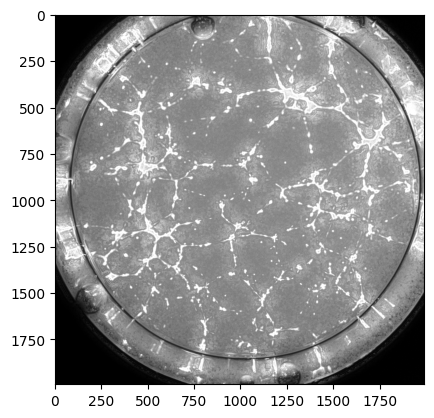

In [9]:
img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

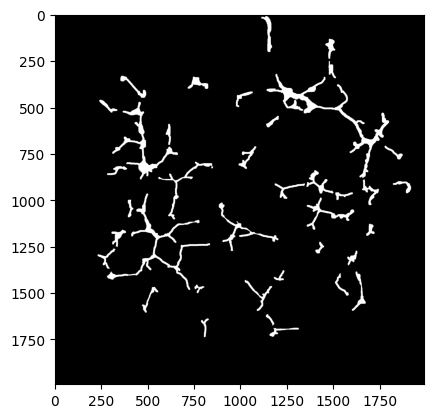

In [10]:
mask = cv2.imread(mask_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap="gray")

# Data pipeline

In [11]:
def load_y(batch_mask_paths, img_shape):
    # load binary segmentation masks
    y = np.zeros((len(batch_mask_paths),) + img_shape + (1,), dtype=np.uint8)
    for i, path in enumerate(batch_mask_paths):
        mask = cv2.imread(path, 0)
        if mask.shape != img_shape:
            mask = cv2.resize(mask, img_shape, interpolation=cv2.INTER_NEAREST)
        mask[mask>0] = 1
        # add a third dimension to the array
        mask = np.expand_dims(mask, 2)
        y[i] = mask
    return y


def load_x(batch_img_paths, img_shape, t_mean=0, t_std=1):
    # Load the input images and convert them to grayscale
    x = np.zeros((len(batch_img_paths),) + img_shape + (1,), dtype=np.float32)
    for i, path in enumerate(batch_img_paths):
        # Ensure best quality downsampling (interpolation methods overview: https://stackoverflow.com/a/44083113)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img.shape != img_shape:
            img = cv2.resize(img, img_shape, interpolation=cv2.INTER_LANCZOS4)
        img = np.expand_dims(img, 2)    # add a third dimension to the array
        x[i] = img
    return (x - t_mean) / t_std


class BinaryMaskSequence(Sequence):
    """Helper to iterate over the data"""

    def __init__(self, batch_size, img_size, img_paths, seg_paths, random_state,
                load_x, load_y, augmentation_function=None, sample_weights=None, dist_params=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.seg_paths = seg_paths
        self.rs: np.random.RandomState = random_state
        self.load_x = load_x
        self.load_y = load_y
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[1]
            self.bg_weight = sample_weights[0]
        self.dist_params = dist_params
        if dist_params:
            self.t_mean = dist_params["mean"]
            self.t_std = dist_params["std"]
        else:
            self.t_mean = 0
            self.t_std = 1

        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.seg_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size

        batch_img_paths = self.img_paths[i : i + self.batch_size]
        batch_seg_paths = self.seg_paths[i : i + self.batch_size]

        # x, y = d.compute([
        #     d.delayed(self.load_x)(batch_img_paths, self.img_size, self.t_mean, self.t_std),
        #     d.delayed(self.load_y)(batch_seg_paths, self.img_size)
        # ])[0]

        x = self.load_x(batch_img_paths, self.img_size, self.t_mean, self.t_std)
        y = self.load_y(batch_seg_paths, self.img_size)

        print(np.min(x), np.max(x))
        print(np.min(y), np.max(y))

        if self.augmentation_function is not None:
            x, y = self.augmentation_function(x, y)

        # If want to up/down-weight foreground/background pixel loss
        # This is good for images that tend to be imbalanced between foreground
        # and background pixel area.
        if self.sample_weights:
            batch_sample_weights = np.zeros(shape=y.shape)
            batch_sample_weights[y == 1] = self.fg_weight
            batch_sample_weights[y != 1] = self.bg_weight
            return x, y, batch_sample_weights

        return x, y

# Data generator

In [12]:
# Augmentation

transforms = [
    A.Compose([
        A.Rotate(p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
        A.RandomCrop(height=512, width=512),
        A.Flip(p=0.5),
        A.OneOf([
                A.MultiplicativeNoise(p=0.5),
                A.AdvancedBlur(p=0.5)
        ], p=0.8),
        A.OneOf([
            A.RandomGamma(p=0.2),
            A.RandomBrightnessContrast(p=0.4),
            A.RandomToneCurve(scale=0.75, p=0.2),
            A.CLAHE(p=0.2)
        ], p=0.75)
    ]),     # Albumentations pipeline
    get_elastic_dual_transform()    # Elastic distortion at the end
]

batch_augmentor = get_batch_augmentor(transforms)

HERE...

0.48534584045410156


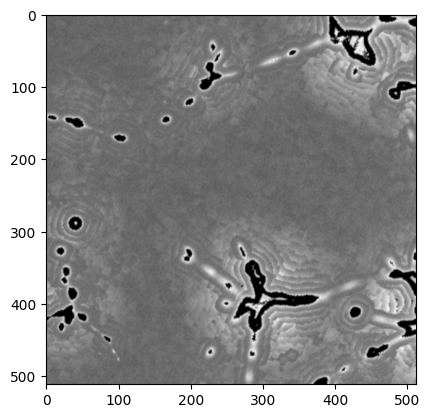

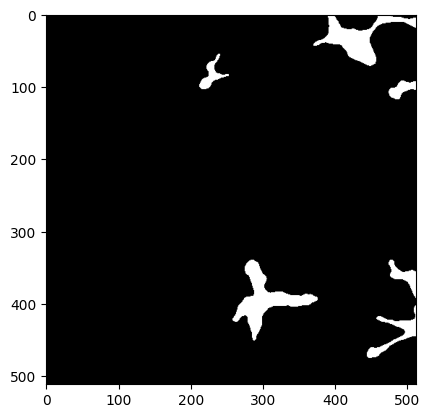

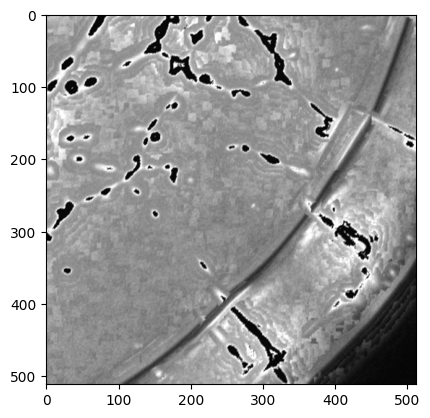

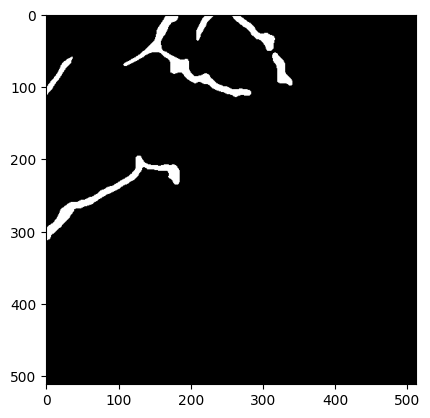

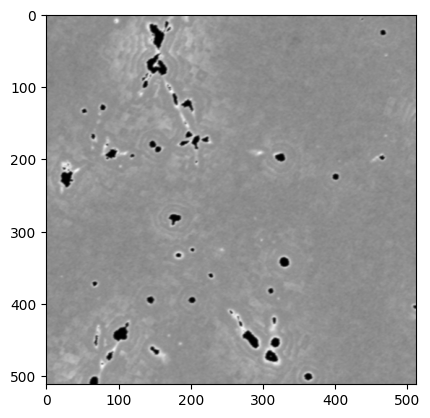

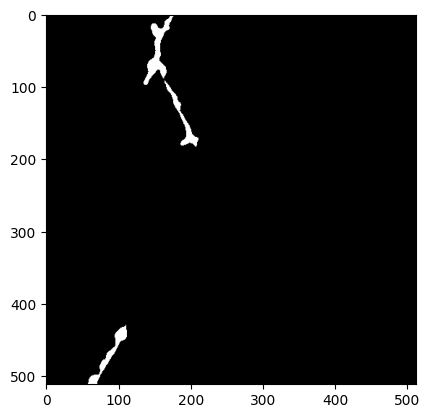

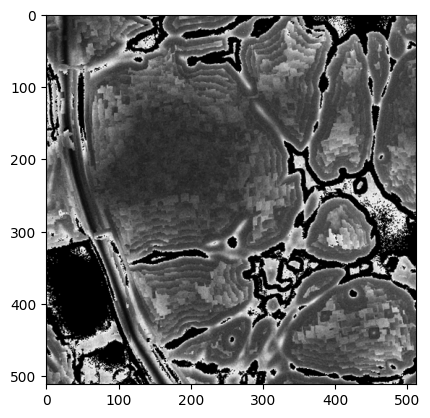

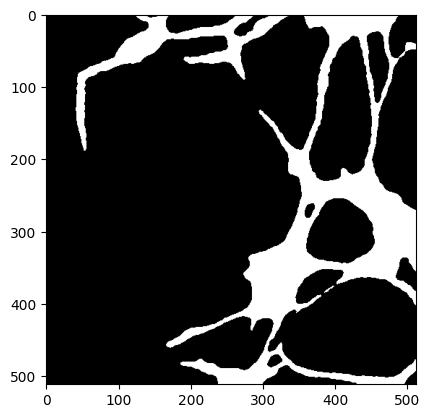

In [13]:
datagen_demo = BinaryMaskSequence(
    batch_size, img_shape, img_paths, mask_paths, rs, load_x, load_y, batch_augmentor
)
start = time.time()
X, y = datagen_demo[0]
stop = time.time()
print(stop - start)
for i in range(4):
    plt.imshow(X[i][:,:,0], cmap='gray')
    plt.show()
    plt.imshow(y[i][:,:,0], cmap='gray')
    plt.show()

# Set up data generators

In [14]:
n_val = int(len(img_paths) * 0.2)
n_test = int(len(img_paths) * 0.2)
# Shuffle data
data_idx = np.array(range(len(img_paths)))
rs.shuffle(data_idx)

In [15]:
traimg_paths = img_paths[: -(n_val + n_test)]
train_mask_paths = mask_paths[: -(n_val + n_test)]

val_img_paths = img_paths[-(n_val + n_test): -n_test]
val_mask_paths = mask_paths[-(n_val + n_test): -n_test]

test_img_paths = img_paths[-n_test:]
test_mask_paths = mask_paths[-n_test:]

## Compute sample weights & mean/std for training data

In [16]:
y_train_labels = load_y(train_mask_paths, img_shape)

In [17]:
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}
sample_weights

{0: 0.5303750021139526, 1: 8.730452102097582}

In [18]:
x_train_imgs = load_x(traimg_paths, img_shape)

In [19]:
d_params = {"mean": np.mean(x_train_imgs), "std": np.std(x_train_imgs)}
d_params

{'mean': 23961.588, 'std': 17050.158}

In [20]:
train_gen = BinaryMaskSequence(batch_size, img_shape, traimg_paths, train_mask_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights, dist_params=d_params)
val_gen = BinaryMaskSequence(batch_size, img_shape, val_img_paths, val_mask_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights, dist_params=d_params)
# No augmentation for test_gen
test_gen = BinaryMaskSequence(batch_size, img_shape, test_img_paths, test_mask_paths, rs, load_x, load_y, dist_params=d_params)

AttributeError: module 'fl_tissue_model_tools.preprocessing' has no attribute 'augment_img_mask_pairs'

# Run grid search

In [ ]:
backend.clear_session()

In [ ]:
# tell tf to use the gpu
# import tensorflow as tf
device(test.gpu_device_name())

In [ ]:
test.gpu_device_name()

In [ ]:
backend.clear_session()

In [ ]:
gs = models.UNetXceptionGridSearch(
    "oxford_pets_grid_search",
    filter_counts_options,
    n_outputs,
    img_shape,
    optimizer=RMSprop(),
    loss=BinaryCrossentropy(),
    metrics=[models.mean_iou_coef_factory(thresh=cls_thresh)],
    output_act="sigmoid"
)

In [ ]:
n_epochs = 5
gs.search(
    "val_mean_iou_coef",
    "max",
    train_gen,
    search_verbose=True,
    validation_data=val_gen,
    epochs=n_epochs
)

In [ ]:
gs.best_filter_counts

In [ ]:
gs.best_score

In [ ]:
gs.best_score_idx

# Load best weights

In [ ]:
best_model = gs.get_best_model()

In [ ]:
test_ex_batch = 10

In [ ]:
test_example_x, test_example_y = test_gen[test_ex_batch]

In [ ]:
test_preds = best_model.predict(test_example_x)

In [ ]:
np.any(np.array([float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[i], axis=0), np.expand_dims(test_preds[i], axis=0))) for i in range(len(test_preds))]) > 1)

In [ ]:
test_ex_idx = 21
test_ex_img = test_example_x[test_ex_idx]
test_ex_pred = test_preds[test_ex_idx]
test_ex_true = test_example_y[test_ex_idx]

In [ ]:
float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[test_ex_idx], axis=0), np.expand_dims(test_preds[test_ex_idx], axis=0)))

In [ ]:
# plt.imshow(test_ex_img, cmap="gray", vmin=0, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow(test_ex_true * 255, cmap="gray", vmin=0, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow(test_ex_pred * 255, cmap="gray", vmin=0, vmax=defs.GS_MAX)
# plt.show()
# plt.imshow((np.greater(test_ex_pred, cls_thresh)).astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=defs.GS_MAX)
# plt.show()

plt.imshow(test_ex_img, cmap="gray")
plt.show()
plt.imshow(test_ex_true, cmap="gray")
plt.show()
plt.imshow(test_ex_pred, cmap="gray")
plt.show()
plt.imshow(np.greater(test_ex_pred, cls_thresh), cmap="gray")
plt.show()